In [1]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

# Import 
import json
import os
from collections import OrderedDict
import pandas as pd
import random
import torch
import torchvision
import numpy as np
from torch import nn
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

In [2]:
data_dir = '/notebooks/flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'
#!unzip /flowers.zip

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
#data_transforms = # 224 -> 256
train_dir_transforms = transforms.Compose([transforms.RandomResizedCrop(224), # before all 225 ##256
                                           transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])])
valid_dir_transforms = transforms.Compose([transforms.Resize(224),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])])
test_dir_transforms = transforms.Compose([transforms.Resize(224),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                               [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
#image_datasets = 
train_data = ImageFolder(train_dir, train_dir_transforms)
valid_set = ImageFolder(valid_dir, valid_dir_transforms)
test_set = ImageFolder(test_dir, test_dir_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
#dataloaders = 
trainloader = torch.utils.data.DataLoader(train_data, batch_size =64, shuffle=True)
valid_data = torch.utils.data.DataLoader(valid_set, batch_size=64)
test_data = torch.utils.data.DataLoader(test_set, batch_size=64)

classes = dict(zip(list(range(len(train_data.classes))),train_data.classes))

In [4]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [5]:
model = models.vit_b_16(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

In [6]:
model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate=none)
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_att

In [7]:
#freeze parameters
for param in model.parameters():
    param.requires_grad = False 

#new classifier for the feedforward
classifier = nn.Sequential(OrderedDict([
                            ('fc1', nn.Linear(768, 320)), #4608,320
                            ('relu', nn.ReLU()),
                            ('dropout', nn.Dropout(0.5)),
                            ('fc2', nn.Linear(320, 300)), #320,300
                            ('relu', nn.ReLU()),
                            ('dropout', nn.Dropout(0.5)),
                            ('fc3', nn.Linear(300, 102)), #300,102
                            ('output', nn.LogSoftmax(dim=1))
                            ]))
model.heads = classifier
print(model)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate=none)
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_att

In [8]:
def create_backup(filename, train_losses, valid_losses, valid_acc):
    torch.save(train_losses, "backups/transformers/train_losses_"+filename)
    torch.save(valid_losses, "backups/transformers/valid_losses_"+filename)
    torch.save(valid_acc, "backups/transformers/valid_acc_"+filename)
    torch.save(model,'models/transformers/model_'+filename+'.pth')
    # Print loss
    cpu_train_losses = []
    cpu_valid_losses = []
    cpu_valid_acc = []

    for tens in train_losses:
        cpu_train_losses.append(tens.to('cpu'))
    plt.plot(cpu_train_losses, label='Training loss')
    plt.plot(valid_losses, label='Validation loss')
    plt.legend(frameon=False)
    plt.savefig('fig/transformers/plot_loss_'+filename+'.jpg')

    plt.clf()
    # Plotting the graph for Validation accuracy wrt Steps
    plt.plot(valid_acc, label='Validation Accuracy')
    plt.legend(frameon=False)
    plt.savefig('fig/transformers/plot_acc_'+filename+'.jpg')

#    with open("backups/cnn/train_losses"+filename, "w") as fp:
#        [fp.write(ele) for ele in train_losses]
#    print("Created train_losses backup")
#    with open("backups/cnn/valid_losses"+filename, "w") as fp:
#        [fp.write(ele) for ele in train_losses]
#    print("Created valid_losses backup")
#    with open("backups/cnn/valid_acc"+filename, "w") as fp:
#        [fp.write(ele) for ele in train_losses]
    print("Created tensor backup")
    

In [9]:
def validation(model, valid_data, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in valid_data:
        
        images,labels = images.to('cuda'), labels.to('cuda')
        
        output = model.forward(images)
        batch_loss = criterion(output, labels)
        test_loss += batch_loss.item()
        
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [10]:
train_losses, valid_losses, valid_acc = [], [], []

In [11]:
model = torch.load('models/transformers/model_checkpoint_epoch_500_lr_1e-05.txt.pth')
model.to("cuda")

train_losses = torch.load('backups/transformers/train_losses_checkpoint_epoch_500_lr_1e-05.txt')
valid_losses = torch.load('backups/transformers/valid_losses_checkpoint_epoch_500_lr_1e-05.txt')
valid_acc = torch.load('backups/transformers/valid_acc_checkpoint_epoch_500_lr_1e-05.txt')
len(valid_acc)

500

In [ ]:
learning_rate=0.00001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.functional.nll_loss
epochs = 390
offset=110
step_of_backup=10
#running_loss = 0
model.to('cuda')
for epoch in range(epochs):
  model.train()
  counter = 0
  for data in trainloader:
    X , y= data
    X , y = X.to('cuda'), y.to('cuda')
    optimizer.zero_grad() # clear gradient information.
    #output = model(X) <- gives errors
    output = model.forward(X)
    loss = criterion(output, y)
    loss.backward() # do pack-propagation step
    optimizer.step() # tell optimizer that you finished batch/iteration.
    counter += 1
    #running_loss += loss.item()
 
 
  # network in eval mode for inference
  model.eval()
            
  # Turn off gradients for validation, saves memory and computations
  with torch.no_grad():
      test_loss, accuracy = validation(model, valid_data, criterion)
  print("Epoch: {}/{}...".format(epoch+1,epochs),
        "Loss: {:.4f}".format(loss.data),
        "Train Loss: {:.3f}.. ".format(test_loss/len(valid_data)),
        "Train Accuracy: {:.3f}".format(accuracy/len(valid_data)))
  train_losses.append(loss.data)
  valid_losses.append(test_loss/len(valid_data))
  valid_acc.append(accuracy/len(valid_data))
  running_loss = 0
  model.train()
  if((epoch+1) % step_of_backup == 0):
    create_backup('checkpoint_epoch_'+str(epoch+1+offset)+'_lr_'+str(learning_rate)+'.txt', train_losses, valid_losses, valid_acc)

create_backup('checkpoint_epoch_'+str(epochs+1+offset)+'_lr_'+str(learning_rate)+'.txt', train_losses, valid_losses, valid_acc)

Epoch: 1/390... Loss: 0.7951 Train Loss: 0.838..  Train Accuracy: 0.814
Epoch: 2/390... Loss: 0.8535 Train Loss: 0.830..  Train Accuracy: 0.817
Epoch: 3/390... Loss: 1.4310 Train Loss: 0.822..  Train Accuracy: 0.817
Epoch: 4/390... Loss: 1.2505 Train Loss: 0.815..  Train Accuracy: 0.819
Epoch: 5/390... Loss: 1.2029 Train Loss: 0.808..  Train Accuracy: 0.819
Epoch: 6/390... Loss: 1.3999 Train Loss: 0.802..  Train Accuracy: 0.819
Epoch: 7/390... Loss: 1.2345 Train Loss: 0.794..  Train Accuracy: 0.823
Epoch: 8/390... Loss: 0.6541 Train Loss: 0.787..  Train Accuracy: 0.828
Epoch: 9/390... Loss: 1.2025 Train Loss: 0.780..  Train Accuracy: 0.830
Epoch: 10/390... Loss: 0.9137 Train Loss: 0.775..  Train Accuracy: 0.828
Created tensor backup
Epoch: 11/390... Loss: 1.2743 Train Loss: 0.769..  Train Accuracy: 0.828
Epoch: 12/390... Loss: 1.1871 Train Loss: 0.761..  Train Accuracy: 0.832
Epoch: 13/390... Loss: 0.8690 Train Loss: 0.755..  Train Accuracy: 0.833
Epoch: 14/390... Loss: 1.3129 Train Lo

In [ ]:
#torch.save(model,'models/transformers/checkpoint_epoch_'+str(len(valid_losses))+'_lr_'+str(learning_rate)+'.pth')
learning_rate=0.00001
# Print loss
cpu_train_losses = []
cpu_valid_losses = []
cpu_valid_acc = []

for tens in train_losses:
    cpu_train_losses.append(tens.to('cpu'))
plt.plot(cpu_train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(frameon=False)
plt.savefig('fig/transformers/manual/trans_plot_loss_epoch_'+str(len(valid_losses))+'_lr_'+str(learning_rate)+'.jpg')

plt.clf()
# Plotting the graph for Validation accuracy wrt Steps
plt.plot(valid_acc, label='Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(frameon=False)
plt.savefig('fig/transformers/manual/trans_plot_acc_epoch_'+str(len(valid_losses))+'_lr_'+str(learning_rate)+'.jpg')

In [13]:
# Evaluate the trained network.
total = 0
correct = 0
model.to('cuda')
with torch.no_grad():   # No need for keepnig track of necessary changes to the gradient.
  for X,y in test_data:
    X , y = X.to('cuda'), y.to('cuda')
    output = model(X)
    for idx, val in enumerate(output):
      if torch.argmax(val) == y[idx]:
        correct += 1
      total += 1
  print('Accuracy:', round(correct/total, 3))

Accuracy: 0.908


[[4 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [1 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 7]]


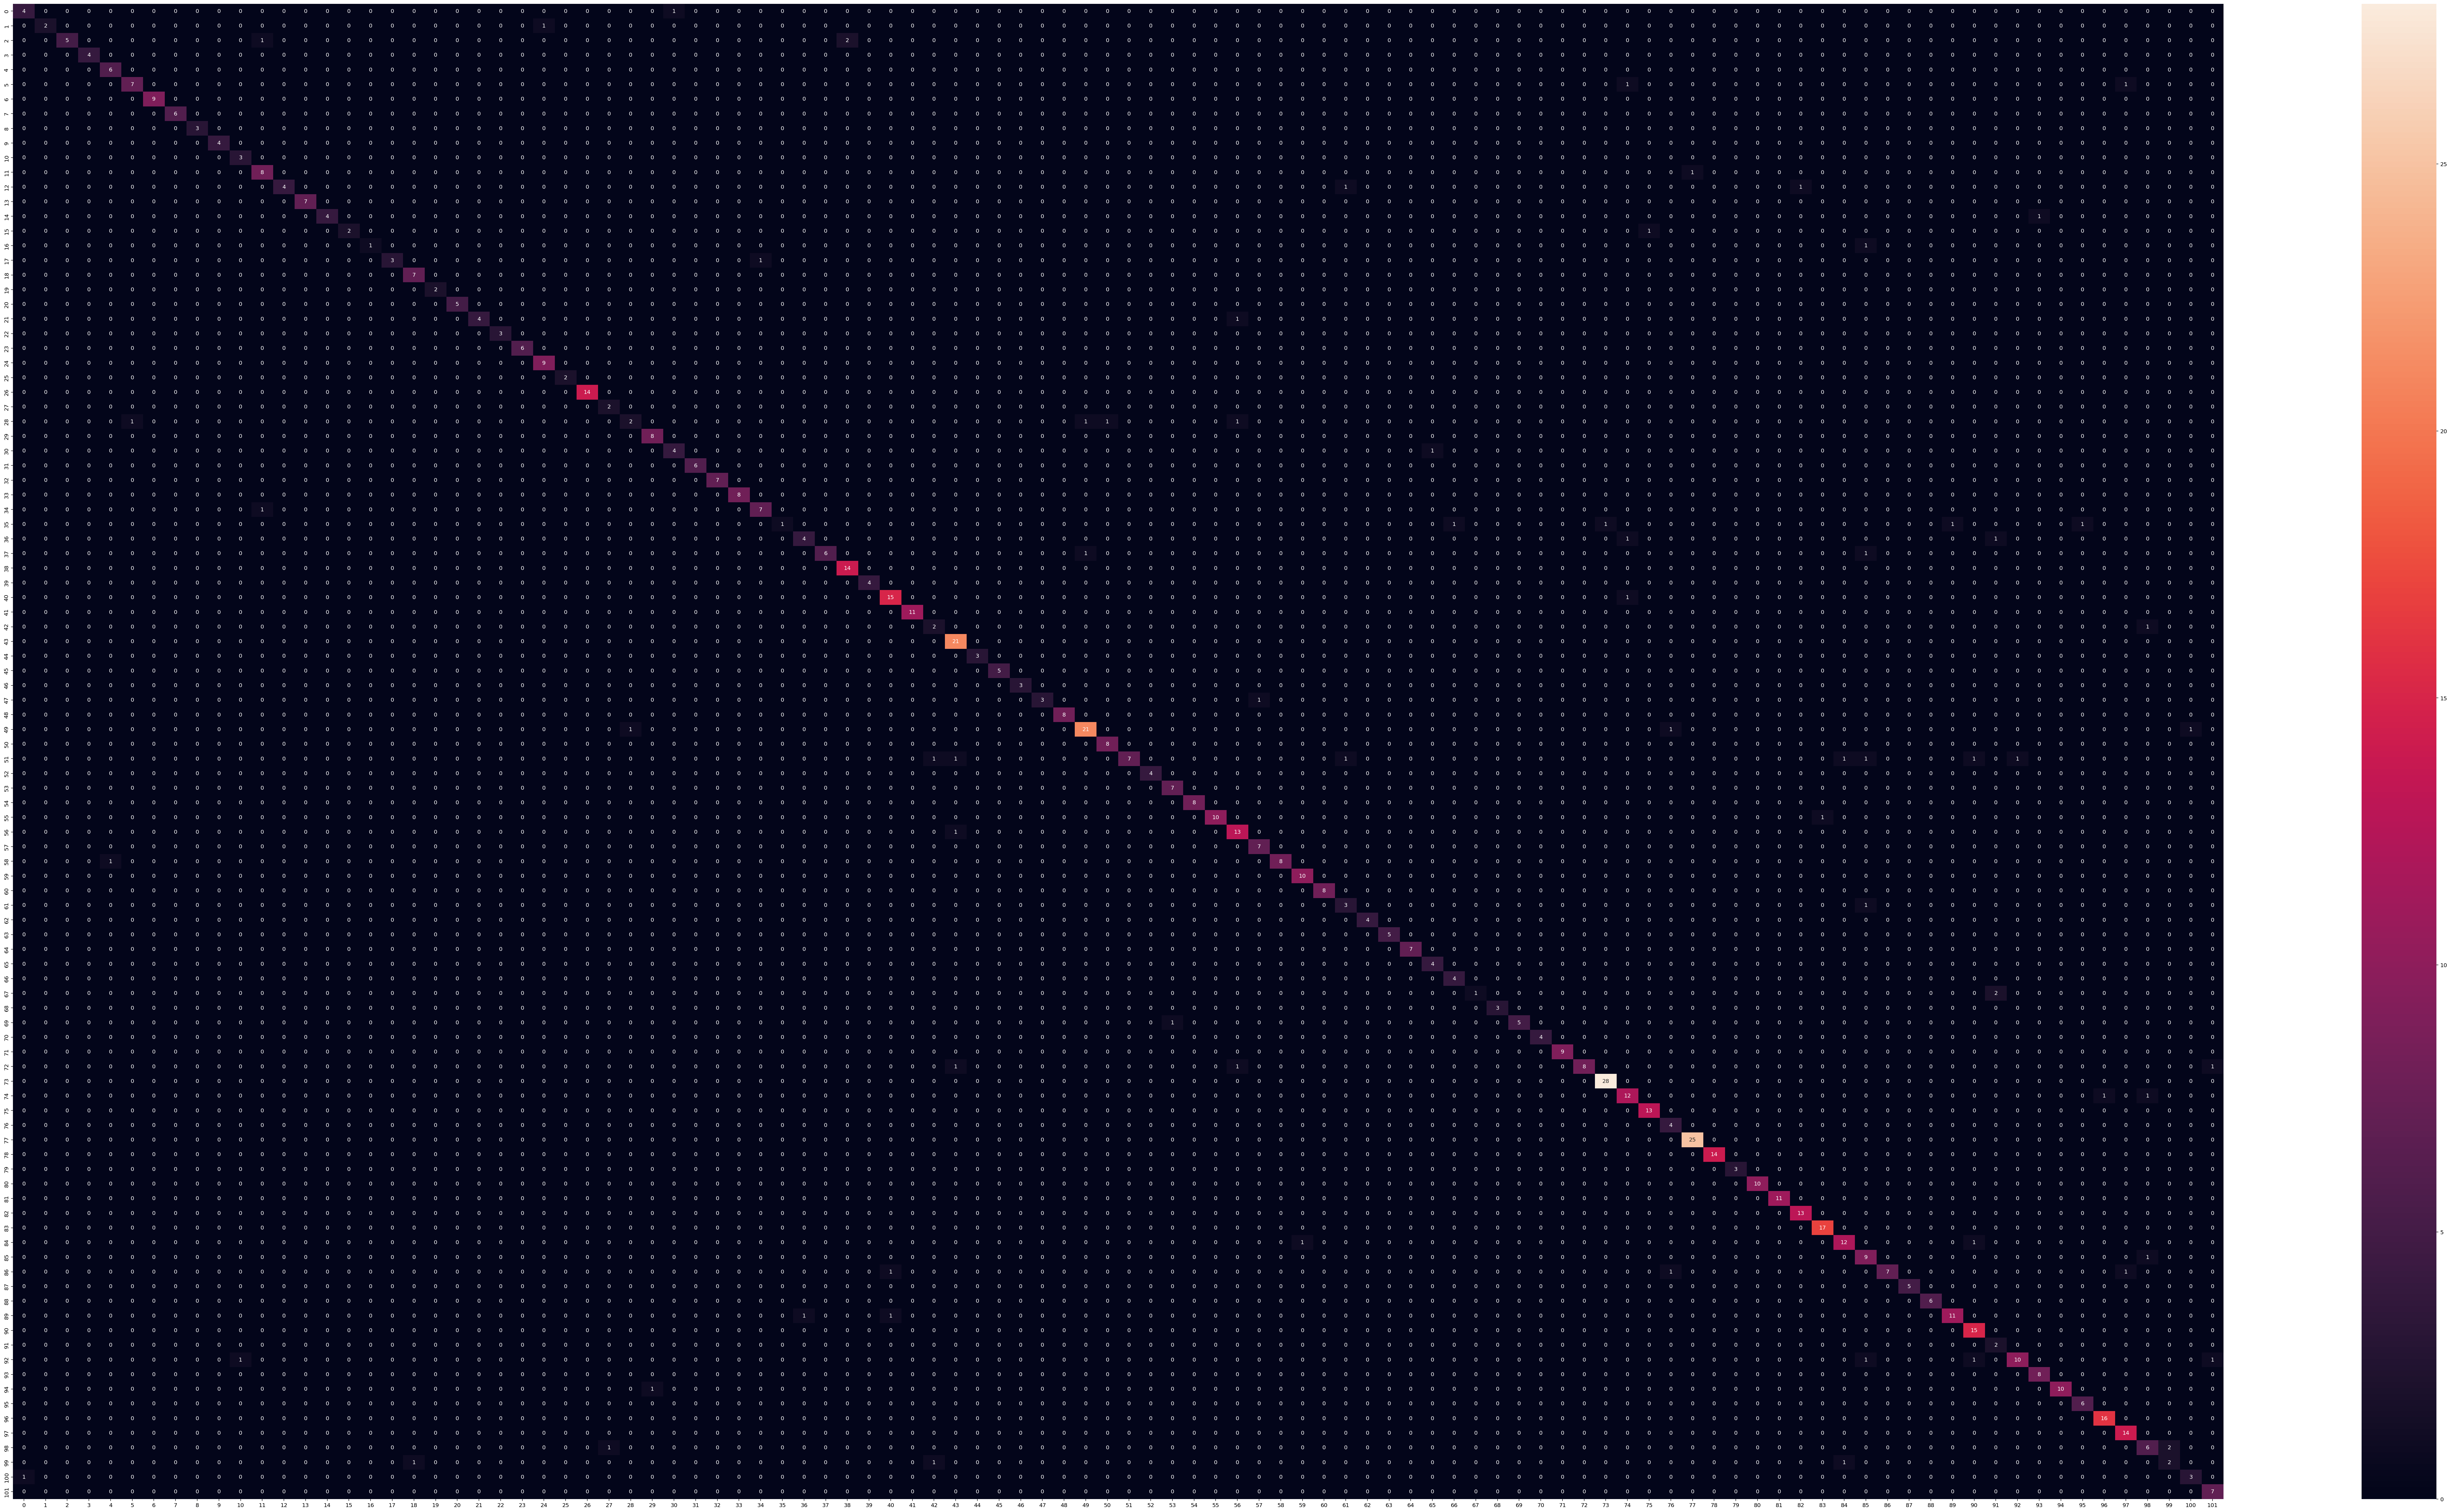

In [21]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_data:
    inputs = inputs.to("cuda")
    output = model(inputs) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction
     
    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

# constant for classes
#classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (90,50))
sn.heatmap(df_cm, annot=True)
plt.savefig('conf-matrix-trans.png')